Detected 8 classes: ['Brown Spot', 'Browon Spot', 'Leaf Scaled', 'Rice Blast', 'Rice Tungro', 'Rice Turgro', 'Shath Blight', 'Sheath Blight']
Epoch 1/10 - Train Loss: 1.3945, Train Acc: 0.4480 - Val Loss: 0.9808, Val Acc: 0.6306
Epoch 2/10 - Train Loss: 0.8926, Train Acc: 0.6572 - Val Loss: 1.0019, Val Acc: 0.6126
Epoch 3/10 - Train Loss: 0.7024, Train Acc: 0.7353 - Val Loss: 0.8741, Val Acc: 0.6982
Epoch 4/10 - Train Loss: 0.4858, Train Acc: 0.8269 - Val Loss: 0.6350, Val Acc: 0.7883
Epoch 5/10 - Train Loss: 0.4080, Train Acc: 0.8733 - Val Loss: 0.5913, Val Acc: 0.7973
Epoch 6/10 - Train Loss: 0.3491, Train Acc: 0.8903 - Val Loss: 0.6062, Val Acc: 0.8063
Epoch 7/10 - Train Loss: 0.3117, Train Acc: 0.8993 - Val Loss: 0.5993, Val Acc: 0.7973
Epoch 8/10 - Train Loss: 0.3184, Train Acc: 0.8937 - Val Loss: 0.5964, Val Acc: 0.8063
Epoch 9/10 - Train Loss: 0.3004, Train Acc: 0.9038 - Val Loss: 0.5935, Val Acc: 0.8153
Epoch 10/10 - Train Loss: 0.3087, Train Acc: 0.8937 - Val Loss: 0.6003, Val

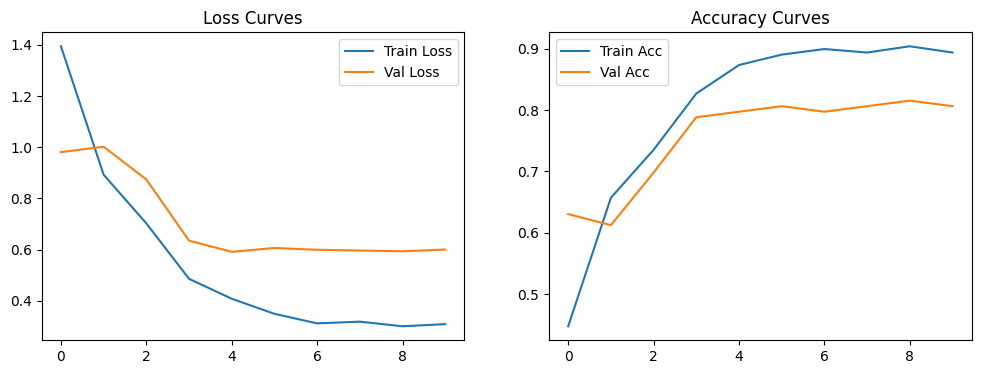

In [19]:
# Install required libraries
!pip install timm

# Import necessary modules
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50
import timm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Define the dataset path (adjust this to your actual path, e.g., mount Google Drive if needed)
dataset_path = '/content/drive/MyDrive/AIUB/CVPR/Final/Paper/Dataset'  # Example: Upload your dataset folder to Colab and set this path

# Collect all image paths and labels (label is the disease folder name)
images = []
labels = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(root, file)
            # The label is the name of the immediate parent folder (disease name)
            label = os.path.basename(root)
            images.append(img_path)
            labels.append(label)

# Get unique labels and map to indices
unique_labels = sorted(set(labels))
label_map = {label: idx for idx, label in enumerate(unique_labels)}
num_classes = len(unique_labels)
print(f"Detected {num_classes} classes: {unique_labels}")

# Split into train and validation sets (80/20 split, stratified)
train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)

# Define transforms (based on the paper's augmentations + standard ones)
# Using 224x224 for both models for simplicity (Swin-T is pretrained on 224)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Simulates random resize + crop
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Random perspective
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Random Gaussian blur
    transforms.RandomHorizontalFlip(),  # Add for extra augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset class
class RiceDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, label_map=None):
        self.image_paths = image_paths
        self.labels = [label_map[label] for label in labels]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Create datasets
train_dataset = RiceDataset(train_images, train_labels, train_transform, label_map)
val_dataset = RiceDataset(val_images, val_labels, val_transform, label_map)

# Create dataloaders
batch_size = 32  # Adjust based on your GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define the hybrid model (ResNet50 + Swin-T)
class HybridModel(nn.Module):
    def __init__(self, num_classes):
        super(HybridModel, self).__init__()

        # ResNet50: already pools to (B, 2048)
        self.resnet = resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()           # → (B, 2048)

        # Swin-Tiny: get the pooled feature (timm does avg pool when head is removed in most cases, but to be safe)
        self.swin = timm.create_model(
            'swin_tiny_patch4_window7_224',
            pretrained=True,
            num_classes=0,          # ← this is better than setting head=Identity()
                                    # It removes the head **and** applies global pooling → (B, 768)
        )
        # No need to set head = Identity() manually when using num_classes=0

        # Classifier on concatenated features
        self.classifier = nn.Sequential(
            nn.Linear(2048 + 768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        res_features = self.resnet(x)           # (B, 2048)
        swin_features = self.swin(x)            # (B, 768)  ← now pooled!

        combined = torch.cat([res_features, swin_features], dim=1)  # (B, 2048+768)
        output = self.classifier(combined)
        return output
# Initialize model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)  # AdamW is good for transformers
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # Optional scheduler

# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    return running_loss / len(loader), correct / total

# Validation function
def val_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return running_loss / len(loader), correct / total

# Training loop
num_epochs = 10  # Adjust as needed
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = val_epoch(model, val_loader, criterion, device)
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

# Save the model (optional)
# torch.save(model.state_dict(), 'hybrid_resnet_swin_model.pth')